In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib.colors import LogNorm
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

In [7]:
class PolyModel(torch.nn.Module):
    def __init__(self, w0: float, in_features: int, out_features: int, w_init: Optional[Tensor] = None) -> None:
        super(PolyModel, self).__init__()
        
        self.w0 = w0
        # The model has two weights w1 and w2 for each output feature
        if w_init is not None:
            assert w_init.shape == (out_features,2, in_features),\
            f"Shape of w_init is {w_init.shape} and should be {(out_features,2,in_features)}"
            self.weight = torch.nn.Parameter(w_init)
        else:
            self.weight = torch.nn.Parameter(torch.randn((out_features, 2, in_features)))
                 
    def forward(self, input: Tensor):
        # Extracting w1 and w2 from the weight tensor
        w1, w2 = self.weight[:, 0, :], self.weight[:, 1, :]
        
        # Computing Q(w1, w2)
        poly = (w1**2 + w2**2 - self.w0) * w1
        return input * poly
    
# Training model

def train_model(model, data_loader, num_epochs = 1000, lr=0.01,momentum=0.9):
    # Loss tracking
    running_loss = []
    running_weight = []
    gradients = []
    # Loss and Optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, 
                          momentum=momentum)

    # Training the Model
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            # Record the current model weight
            current_weight = model.weight.detach().clone()
            running_weight.append(current_weight)
            # Forward pass
            y_pred = model(batch_x)
            loss = loss_function(y_pred, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            gradients.append(model.weight.grad.clone())
            optimizer.step()

            # Tracking the cumulative loss for the current epoch
            epoch_loss += loss.item()

        # Calculate average loss for the current epoch
        avg_epoch_loss = epoch_loss / len(data_loader)
        running_loss.append(avg_epoch_loss)


        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_epoch_loss}')

    # Print the first 10 gradient values
    print("First 10 gradient values:")
    for i in range(min(10, len(gradients))):
        print(gradients[i])
        
    return running_loss, running_weight

# Plot loss curve

def plot_loss_curve(running_loss):
    plt.plot(running_loss)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Plot loss landscape

def plot_loss_landscape(model, x_data, y_data, 
                        weight_range, running_weight, linear=False):

    # Computing the loss for each weight value in the range
    loss_landscape = []
    loss_function = nn.MSELoss()

    for weight in weight_range:
        # Updating the model's weight and fixed bias
        if linear == True:
            model.linear.weight.data.fill_(weight)
        else:
            model.weight.data.fill_(weight) 
        
        # Forward pass with the updated weight
        y_pred = model(x_data)
        
        # Computing the loss
        loss = loss_function(y_pred, y_data)
        loss_landscape.append(loss.item())

    # Plotting the loss landscape
    
    plt.plot(weight_range, loss_landscape, label='Loss Landscape')

    # Plotting the trajectory of the weights during training
    plt.plot(running_weight, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in running_weight], 'ro-', label='Training Path', markersize=3)
    plt.title('Weight Dynamics on Loss Landscape')
    plt.yscale("log")
    plt.xlabel('Weight')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Train 2D polynomial model

Epoch 0, Loss: 1.0669701330736279
Epoch 10, Loss: 1.0549883545935155
Epoch 20, Loss: 1.0552791252359748
Epoch 30, Loss: 1.0572689405269922
Epoch 40, Loss: 1.055826945900917
Epoch 50, Loss: 1.056457223445177
Epoch 60, Loss: 1.0552694442868233
Epoch 70, Loss: 1.0553193610534073
Epoch 80, Loss: 1.0551724566146732
Epoch 90, Loss: 1.0560638444870711
Epoch 100, Loss: 1.0552293938025832
Epoch 110, Loss: 1.0560176093503832
Epoch 120, Loss: 1.0579719960317016
Epoch 130, Loss: 1.055200557783246
Epoch 140, Loss: 1.0553125513717532
Epoch 150, Loss: 1.0551759136095642
Epoch 160, Loss: 1.055176767706871
Epoch 170, Loss: 1.0550639176741243
Epoch 180, Loss: 1.0550287653133272
Epoch 190, Loss: 1.05505874119699
First 10 gradient values:
tensor([[[0.7102],
         [0.0000]]])
tensor([[[ 1.2068],
         [-0.0036]]])
tensor([[[-0.6424],
         [ 0.0069]]])
tensor([[[-0.2236],
         [ 0.0033]]])
tensor([[[-0.0118],
         [ 0.0002]]])
tensor([[[-0.7213],
         [ 0.0148]]])
tensor([[[ 0.7678],
 

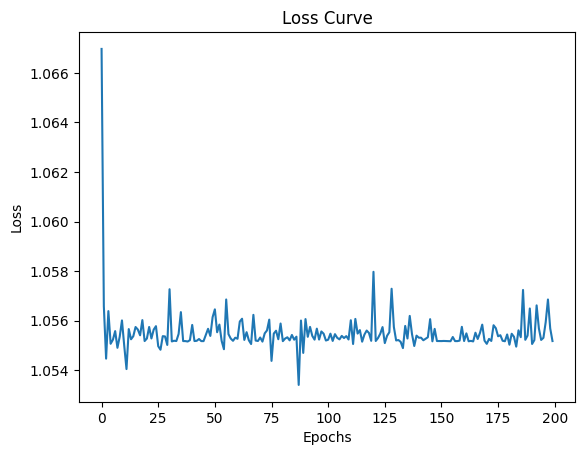

In [10]:
# Pramaters
lr = 0.01
momentum = 0.9
num_epochs = 200
num_samples = 1000
batch_size = 5
num_trajectories = 1
trajectory = []
# Generate data
wx_init = 0
wy_init = -0.2
# Truth
w0 = 1.0

for i in range(num_trajectories):
    w_init = torch.tensor([[[wx_init], [wy_init]]])
    model = PolyModel(w0=w0,in_features=1, out_features=1, w_init=w_init)
    x_data = torch.normal(0, 1, (num_samples, 1))
    y_data = torch.normal(0, 1, (num_samples, 1))
    dataset = TensorDataset(x_data, y_data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # Training
    loss_values, running_weights =  train_model(model, data_loader,num_epochs = num_epochs, lr=lr, momentum=momentum)
    trajectory.append(running_weights)
    plot_loss_curve(loss_values)

Visualise one trajectory on loss landscape

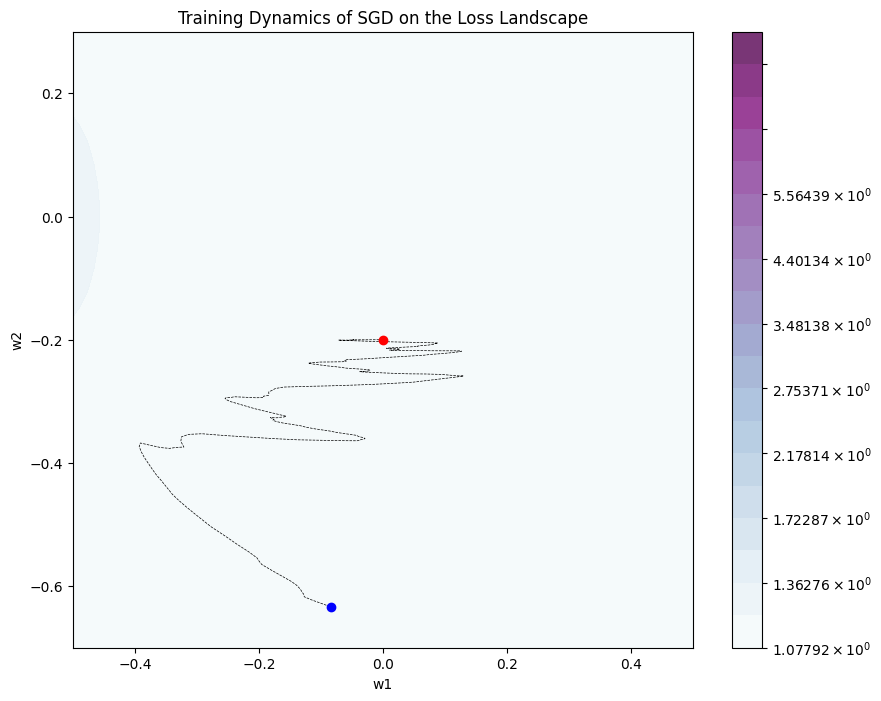

In [16]:
# Plot loss landscape
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
running_weight = trajectory[0]
# Weights trajectory
wx = [running_weight[i][:,0,:].item() for i in range(num_epochs)]
wy = [running_weight[i][:,1,:].item() for i in range(num_epochs)]

wmax = max(abs(num) for num in wx + wy) + 1

# Generate a grid of w1 and w2 values
w1_range = np.linspace(-wmax, wmax, 100)
w2_range = np.linspace(-wmax, wmax, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)

model = PolyModel(w0=1.0, in_features=1, out_features=1)  # Initialize with the given w0 value
loss_function = torch.nn.MSELoss()

loss_landscape = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w1_val = W1[i, j]
        w2_val = W2[i, j]
        
        # Set the weight values in the model correctly as a 3D tensor
        model.weight.data = torch.tensor([[[w1_val], [w2_val]]])
        
        # Compute the loss
        y_pred = model(x_data)
        loss = loss_function(y_pred, y_data)
        loss_landscape[i, j] = loss.item()


# Plot the contour map of the loss landscape
plt.figure(figsize=(10, 8))
contour = plt.contourf(W1, W2, loss_landscape, levels=np.logspace(np.log10(np.min(loss_landscape)),1,num=20), norm= LogNorm(), cmap='BuPu', alpha=0.8)
plt.colorbar(contour)
# Visualise weights trajectory
plt.plot(wx, wy, 'k--', linewidth=0.5, markersize=0.1)
plt.plot(wx[0], wy[0], 'ro')
plt.plot(wx[-1], wy[-1], 'bo')
plt.title("Training Dynamics of SGD on the Loss Landscape")
plt.xlabel("w1")
plt.ylabel("w2")
plt.xlim((-0.5,0.5))
plt.ylim((wy_init - 0.5, wy_init + 0.5))
plt.show()

Visualise multiple trajectories on the loss landscape

In [5]:
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
# Generate a grid of w1 and w2 values
w1_range = np.linspace(-wmax, wmax, 100)
w2_range = np.linspace(-wmax, wmax, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)
model = PolyModel(w0=1.0, in_features=1, out_features=1)  # Initialize with the given w0 value
loss_function = torch.nn.MSELoss()

loss_landscape = np.zeros_like(W1)
running_weight = trajectory[0]
# Generate loss landscape
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w1_val = W1[i, j]
        w2_val = W2[i, j]
        
        # Set the weight values in the model correctly as a 3D tensor
        model.weight.data = torch.tensor([[[w1_val], [w2_val]]])
        
        # Compute the loss
        y_pred = model(x_data)
        loss = loss_function(y_pred, y_data)
        loss_landscape[i, j] = loss.item()

# Plot the contour map of the loss landscape
plt.figure(figsize=(10, 8))
contour = plt.contourf(W1, W2, loss_landscape, levels=np.logspace(np.log10(np.min(loss_landscape)),1,num=20), norm= LogNorm(), cmap='BuPu', alpha=0.8)
plt.colorbar(contour)
# Plot each trajectory
for traj in trajectory:
    running_weight = traj
    # Weights trajectory
    wx = [running_weight[i][:,0,:].item() for i in range(num_epochs)]
    wy = [running_weight[i][:,1,:].item() for i in range(num_epochs)]
    wmax = max(abs(num) for num in wx + wy) + 1
    # Visualise weights trajectory
    plt.plot(wx, wy, 'k--', linewidth=0.5, markersize=0.1)
    plt.plot(wx[0], wy[0], 'ro')
    plt.plot(wx[-1], wy[-1], 'bo')
    plt.title("Training Dynamics of SGD on the Loss Landscape")
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.xlim((-0.25,0.25))
    plt.ylim((wy_init - 0.05, wy_init + 0.1))

plt.show()

NameError: name 'wmax' is not defined

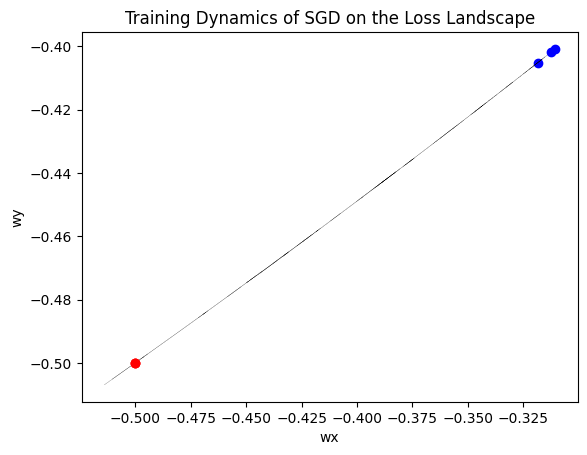

In [15]:
# Visualise weights trajectory
for traj in trajectory:
    running_weight = traj
    wx = [running_weight[i][:,0,:].item() for i in range(num_epochs)]
    wy = [running_weight[i][:,1,:].item() for i in range(num_epochs)]
    plt.plot(wx, wy, 'k--', linewidth=0.1, markersize=0.1)
    plt.plot(wx[0], wy[0], 'ro')
    plt.plot(wx[-1], wy[-1], 'bo')
    plt.title("Training Dynamics of SGD on the Loss Landscape")
    plt.xlabel("wx")
    plt.ylabel("wy")
plt.show()

In [13]:
print(w_init)

tensor([[[ 0.2973],
         [-0.3948]]])


In [15]:
print(np.min(loss_landscape))
print(np.max(loss_landscape))

0.9749467481150662
48.26257087871973
